In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime


##1. Carregamento e preparação dos dados

Os dados vêm do Olist, um marketplace brasileiro. Para personalizar ofertas, precisamos unir informações de pedidos, clientes, pagamentos e itens comprados.

In [ ]:
# Carregar os dados
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_payments = pd.read_csv("olist_order_payments_dataset.csv")
df_items = pd.read_csv("olist_order_items_dataset.csv")

# Preparação dos dados
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

# Data de referência (exemplo: último pedido no dataset)
data_referencia = df_orders["order_purchase_timestamp"].max()

# Mesclar datasets para obter informações de compra por cliente
df_merged = df_orders.merge(df_customers, on="customer_id") \
                     .merge(df_payments, on="order_id") \
                     .merge(df_items, on="order_id")


##2. Criação da Tabela RFM

A segmentação RFM agrupa clientes com base em:

- Recência (R): Quanto tempo se passou desde a última compra?
- Frequência (F): Quantas compras o cliente fez?
- Monetário (M): Quanto o cliente gastou no total?

Isso é essencial para entender o comportamento dos clientes e direcionar estratégias de marketing.

In [34]:
# Criando a base RFM
df_rfm = df_merged.groupby("customer_unique_id").agg({
    "order_purchase_timestamp": lambda x: (data_referencia - x.max()).days,  # Recência
    "order_id": "count",  # Frequência
    "payment_value": "sum"  # Monetário
}).rename(columns={"order_purchase_timestamp": "recencia", "order_id": "frequencia", "payment_value": "monetario"})

print(df_rfm.describe())

           recencia    frequencia      monetario
count  95419.000000  95419.000000   95419.000000
mean     287.123141      1.232469     212.831142
std      153.150855      0.823064     641.763082
min       44.000000      1.000000       9.590000
25%      163.000000      1.000000      63.910000
50%      268.000000      1.000000     113.150000
75%      396.000000      1.000000     202.545000
max      772.000000     75.000000  109312.640000


###Análise das saídas

**1. Recência (R): Tempo desde a última compra (em dias)**
- Média: 287 dias (9,5 meses) → Em média, os clientes fizeram sua última compra há quase 10 meses.
- Mínimo: 44 dias → O cliente mais recente fez sua última compra há 44 dias.
- Máximo: 772 dias (2 anos e 1 mês) → Alguns clientes estão inativos há mais de 2 anos.

Distribuição:
- 50% (mediana) dos clientes compraram há mais de 268 dias (9 meses).
- 25% mais recentes compraram há até 163 dias (5,5 meses).
- 25% mais antigos compraram há mais de 396 dias (1 ano e 1 mês).

**2. Frequência (F): Quantidade de compras por cliente**
- Média: 1,23 compras → A maioria dos clientes comprou apenas uma vez.
- Mínimo: 1 compra → Muitos clientes compraram apenas uma vez e nunca mais voltaram.
- Máximo: 75 compras → Existem alguns clientes muito fiéis.

Distribuição:
- 50% dos clientes compraram apenas 1 vez (mediana = 1).
- 25% dos clientes compraram mais de 1 vez, mas menos de 2 vezes.

**3. Monetário (M): Total gasto por cliente (em R$)**
- Média: 212,83 → Em média, um cliente gasta pouco mais de 200 no e-commerce.
- Mínimo: 9,59 → Alguns clientes gastam valores muito baixos.
- Máximo: 109.312,64 → Existe um grupo de clientes que gasta muito.

Distribuição:
- 50% dos clientes gastaram menos 113,15.
- 25% mais lucrativos gastaram mais de 202,54.

**Conclusão até aqui:**

Os dados mostram que o e-commerce tem:

- Muitos clientes inativos (média de quase 10 meses desde a última compra).
- Pouca retenção (a maioria compra apenas uma vez).
- Um pequeno grupo de clientes VIPs que fazem compras recorrentes e gastam muito.

# 3. Visualizações para entender padrões

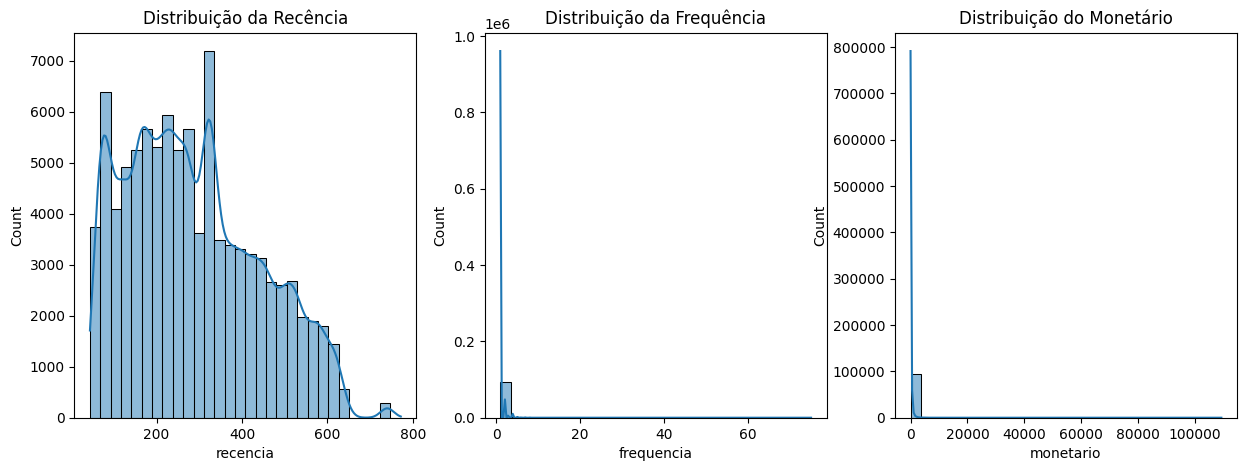

In [35]:
# Visualizações para entender os padrões
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df_rfm["recencia"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribuição da Recência")
sns.histplot(df_rfm["frequencia"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribuição da Frequência")
sns.histplot(df_rfm["monetario"], bins=30, kde=True, ax=axes[2])
axes[2].set_title("Distribuição do Monetário")
plt.show()

**1. Distribuição da Recência (Gráfico 1 - Esquerda)**
- A maior parte dos clientes fez a última compra entre 100 e 400 dias atrás.
- Existe um pico significativo em torno de 300 dias, indicando um grupo grande de clientes que parou de comprar há quase um ano.
- O número de clientes diminui à medida que os dias aumentam, mas há um número considerável de clientes inativos há mais de 600 dias.

*O que isso significa?*

- Muitos clientes estão inativos há quase um ano, indicando a necessidade de campanhas de reativação (descontos, ofertas exclusivas para clientes antigos).
- Clientes recentes são poucos → O e-commerce pode precisar de ações para atrair novos consumidores e manter os existentes engajados.

**2. Distribuição da Frequência (Gráfico 2 - Centro)**
- A grande maioria dos clientes comprou apenas uma vez, evidenciado pelo enorme pico em Frequência = 1.
- Há um número pequeno de clientes com mais de 10 compras, mas são exceções.

*O que isso significa?*

O e-commerce não consegue reter clientes — a maioria compra uma única vez e não retorna.

**3. Distribuição do Monetário (Gráfico 3 - Direita)**
- A maioria dos clientes gastou valores baixos (pico perto de 100 e 200).
- Existem outliers que gastaram valores muito altos (acima de 50.000), mas são poucos.

*O que isso significa?*

A maior parte dos clientes tem ticket médio baixo.

# 4. Dados para clustering

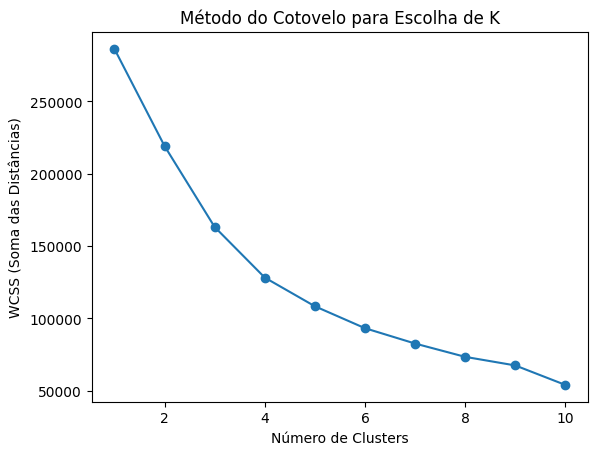

In [36]:
# Normalização dos dados para clustering
scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(df_rfm)

# Escolha do número de clusters com Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS (Soma das Distâncias)")
plt.title("Método do Cotovelo para Escolha de K")
plt.show()

In [37]:
# Baseado no gráfico, escolhemos K=4 (exemplo)
kmeans = KMeans(n_clusters=4, random_state=42)
df_rfm["cluster"] = kmeans.fit_predict(df_rfm_scaled)


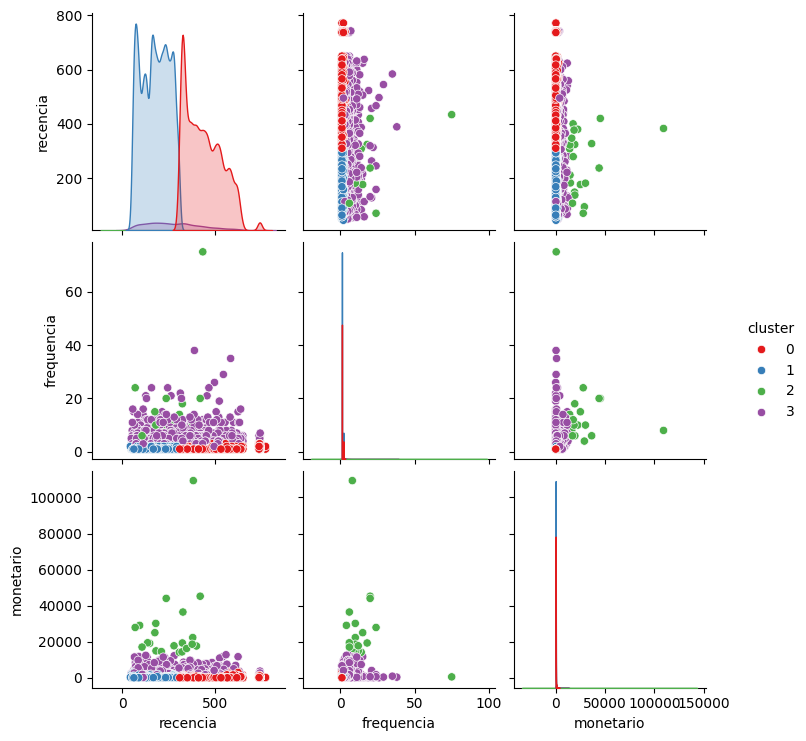

           recencia  frequencia     monetario
cluster                                      
0        437.782086    1.123559    170.853317
1        177.159935    1.115238    170.154768
2        265.636364   14.227273  26086.449545
3        277.691581    4.053348   1135.653520


In [38]:
# Visualização dos clusters
sns.pairplot(df_rfm, hue="cluster", palette="Set1")
plt.show()

# Interpretação dos clusters
print(df_rfm.groupby("cluster").mean())

# Sugestões de ofertas personalizadas para cada cluster:
# - **Cluster 0 (Clientes Dormindo)** → Última compra foi há muito tempo, baixo gasto → Ofertas de reativação, cupons de desconto
# - **Cluster 1 (Clientes Frequentes, Baixo Gasto)** → Compram sempre, mas gastam pouco → Promoções de upsell, descontos progressivos
# - **Cluster 2 (Clientes VIP)** → Alta frequência e alto gasto → Benefícios exclusivos, programa de fidelidade premium
# - **Cluster 3 (Novos Clientes ou Clientes Ocasionalmente Ativos)** → Alta recência, mas ainda compram pouco → Incentivos para engajamento, descontos em próximas compras


# 5. Análise final dos clusters + ofertas

**📌 Cluster 0 – "Clientes dormindo" 😴**

📊 Média dos atributos:

- Recência: 437 dias (faz muito tempo desde a última compra).
- Frequência: 1,12 (compraram apenas uma vez).
- Monetário: R$ 170,85 (gasto baixo).

*O que significa?*

Esses clientes não compram há muito tempo e, quando compraram, gastaram pouco.
Provavelmente esqueceram do e-commerce ou não encontraram motivos para voltar.

*🚀 Estratégias para reativação:*
- Ofertas especiais para ex-clientes (cupom de R$ X para reativação).
- Campanhas de e-mail marketing personalizadas ("Sentimos sua falta! Um presente para você!").
- Retargeting com anúncios e promoções exclusivas.


**📌 Cluster 1 – "Clientes frequentes, baixo gasto" 🔄**

📊 Média dos atributos:

- Recência: 177 dias (tempo razoável desde a última compra).
- Frequência: 1,11 (compraram apenas uma vez, mas são mais recentes que o Cluster 0).
- Monetário: R$ 170,15 (gasto médio-baixo).

*O que significa?*

São clientes recentes que fizeram poucas compras e gastaram pouco. Provavelmente são novos clientes que ainda não se fidelizaram.

*🚀 Estratégias para incentivar compras recorrentes:*
- Descontos progressivos para a segunda compra (ex: "10% de desconto na sua próxima compra!").
- Cross-selling e upselling → Sugerir produtos complementares baseados na compra anterior.
- Programa de fidelidade leve (cashback pequeno para incentivar a segunda compra).


**📌 Cluster 2 – "Clientes VIP" 👑**

📊 Média dos atributos:

- Recência: 265 dias (compram com frequência razoável).
- Frequência: 14,2 (muito acima dos outros clusters).
- Monetário: R$ 26.086,44 (altíssimo ticket médio).

*O que significa?*

Esses clientes compram muitas vezes e gastam muito. Representam o grupo mais valioso do e-commerce e precisam ser tratados com exclusividade.

*🚀 Estratégias para manter e fidelizar esse grupo:*
- Programa VIP (descontos exclusivos, frete grátis, pré-venda de lançamentos).
- Atendimento diferenciado (e-mails personalizados, canal direto de suporte).
- Brindes ou amostras grátis para recompensar a lealdade.


**📌 Cluster 3 – "Novos clientes ou clientes ocasionalmente ativos" 🔥**

📊 Média dos atributos:

- Recência: 277 dias (intermediário).
- Frequência: 4,05 (compram mais que a média, mas não são recorrentes como o Cluster VIP).
- Monetário: R$ 1135,65 (gasto razoável, mas muito abaixo do Cluster VIP).

*O que significa?*

Esses clientes têm potencial para se tornarem VIPs caso sejam bem trabalhados. São clientes ativos, mas ainda sem recorrência alta.

*🚀 Estratégias para aumentar a frequência de compra:*
- Campanhas de retenção (descontos personalizados para continuar comprando).
- Sugestão de novos produtos baseados no histórico de compras.
- Promoções sazonais exclusivas para criar um senso de urgência.



**📊 Resumo**

- 0 – Clientes Dormindo 😴	Compraram há muito tempo, gastaram pouco. Campanhas de reativação, cupons de desconto, retargeting
- 1 – Clientes Frequentes, Baixo Gasto 🔄	Compraram recentemente, mas gastaram pouco.Incentivos para recompra, cross-selling, programa de fidelidade
- 2 – Clientes VIP 👑	Compram com muita frequência e gastam muito. Programa VIP, atendimento diferenciado, recompensas
- 3 – Novos Clientes / Ocasionalmente Ativos 🔥	Compram de vez em quando e têm gasto intermediário. Promoções para aumentar frequência, ofertas personalizadas
